<a href="https://colab.research.google.com/github/darshan-kale-dsi/Bank-Marketing-Campaign/blob/seb_branch/notebooks/model_adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Adjustment

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import SMOTENC, SMOTE
import missingno as msno
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics
import os
import pickle
from pathlib import Path
import shap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


## Loading Data

<Axes: >

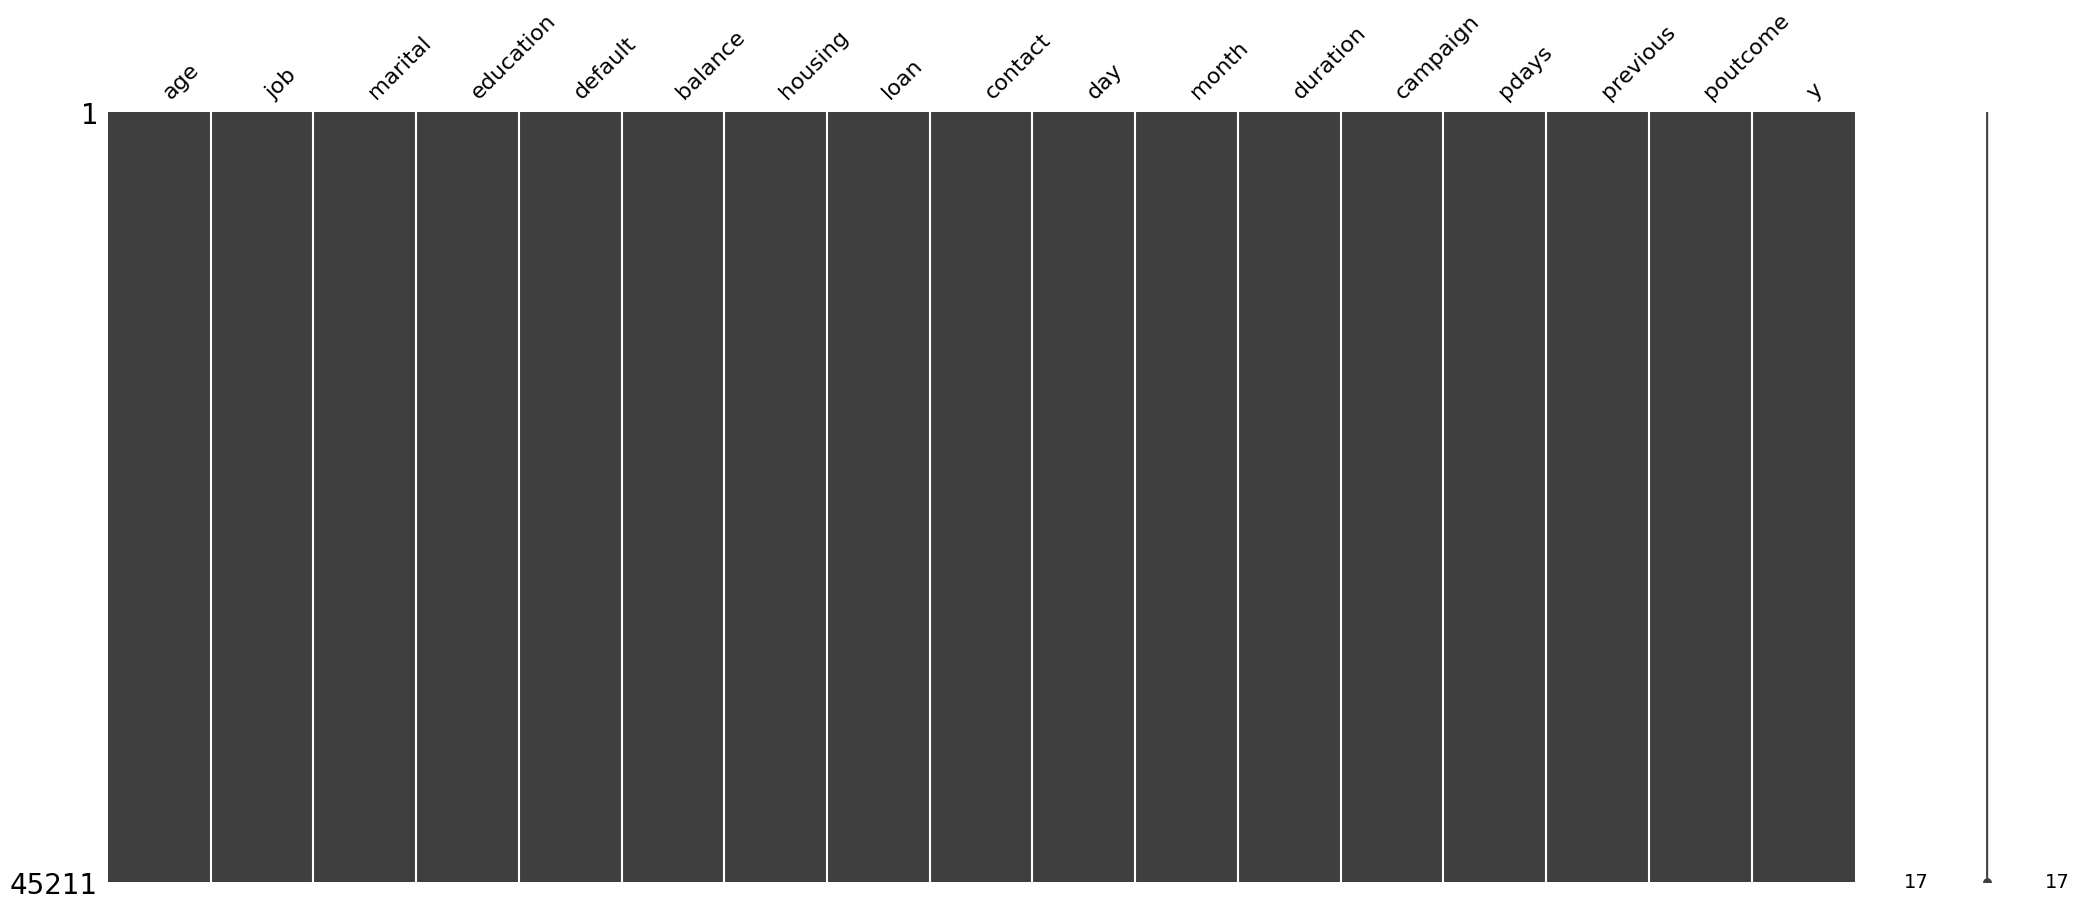

In [59]:
dataframe = pd.read_csv('bank-full.csv', sep = ';')
msno.matrix(dataframe) # no missing values

## Feature Engineering

In [60]:
# trimming extreme values (outliers)
dataframe = dataframe[(dataframe['balance']<10000) & (dataframe['duration']<1800)]

# Coding features
dataframe['pdays'] = dataframe['pdays'].apply(lambda value: 0 if value==-1 else 1 )
dataframe['default'] = dataframe['default'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['housing'] = dataframe['housing'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['loan'] = dataframe['loan'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['y']= dataframe['y'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['month'] = dataframe['month'].replace({'may':5,
                              'jun':6,
                              'jul':7,
                              'aug':8,
                              'oct':10,
                              'nov':11,
                              'dec':12,
                              'jan':1,
                              'feb':2,
                              'mar':3,
                              'apr':4,
                              'sep':9})


## Adding cyclicla enconding
dataframe['day_sine'] = dataframe['day'].apply(lambda value: np.sin(2*value*np.pi/31))
dataframe['day_cosine'] = dataframe['day'].apply(lambda value: np.cos(2*value*np.pi/31))

dataframe['month_sine'] = dataframe['month'].apply(lambda value: np.sin(2*value*np.pi/12))
dataframe['month_cosine'] = dataframe['month'].apply(lambda value: np.cos(2*value*np.pi/12))

dataframe = dataframe.drop(['day', 'month'], axis = 1)


<ipython-input-60-108d4a7bb74c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['pdays'] = dataframe['pdays'].apply(lambda value: 0 if value==-1 else 1 )
<ipython-input-60-108d4a7bb74c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['default'] = dataframe['default'].apply(lambda value: 1 if value =='yes' else 0)
<ipython-input-60-108d4a7bb74c>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

## Designing Pipelinem

In [61]:
numeric_columns = ['age', 'default', 'balance', 'housing',
                   'loan', 'campaign', 'pdays', 'previous', 'day_sine',
                   'day_cosine', 'month_sine', 'month_cosine', 'duration']



categorical_columns = ['job','marital', 'education','contact','poutcome']
preprocessor = ColumnTransformer(
    transformers=[('num',StandardScaler(),numeric_columns),
                  ('cat',OneHotEncoder(drop='first'),categorical_columns)
                  ]
    )


pipeline = Pipeline(  [
        ('preprocessor', preprocessor),
        # ('model', XGBClassifier()) # Base model
        ('model', XGBClassifier(colsample_bytree = 0.5, ## Best model!
                      gamma = 0.0,
                      learning_rate = 0.1,
                      max_depth = 12,
                      reg_alpha = 1,
                      reg_lambda = 1e-5))
    ])

## Data Balancing
As data is quite unbalenced, SMOTE techinques were applied to build a balanced dataset

In [7]:

X = dataframe.drop('y', axis = 1)
y = dataframe['y']

sm = SMOTENC(random_state=42,
             categorical_features = categorical_columns)

# sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

## Splitting data

In [52]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 123)

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan',
                                                   'campaign', 'pdays',
                                                   'previous', 'day_sine',
                                                   'day_cosine', 'month_sine',
                                                   'month_cosine',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome'])])),
                ('model',
                 XGBClassifier(base_score...
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## Model development

In [ ]:
# model = BernoulliNB()
# model = KNeighborsClassifier()
# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model = RandomForestClassifier()
# model = XGBClassifier()
# model = XGBClassifier(colsample_bytree = 0.5,
#                       gamma = 0.0,
#                       learning_rate = 0.1,
#                       max_depth = 12,
#                       reg_alpha = 1,
#                       reg_lambda = 1e-5)
# 'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'reg_alpha': 1, 'reg_lambda': 1e-05

# model = LogisticRegression()
# model = svm.SVC()
# model.fit(X_train_processed, y_train)
# y_hat = model.predict(X_test_processed)
# print(accuracy_score(y_test, y_hat))
# print(confusion_matrix(y_test, y_hat))

## Overall assessment metrics

In [10]:


Y_pred_train = pipeline.predict(X_train)
Y_pred_test = pipeline.predict(X_test)
Y_poba_train = pipeline.predict_proba(X_train)
Y_proba_test = pipeline.predict_proba(X_test)

res = {
    'accuracy_score_train': accuracy_score(y_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(y_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(y_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(y_test, Y_pred_test),
    'log_loss_train': log_loss(y_train, Y_poba_train),
    'log_loss_test': log_loss(y_test, Y_proba_test),
    'f1_score_train': f1_score(y_train, Y_pred_train),
    'f1_score_test': f1_score(y_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.9923743279677105,
 'accuracy_score_test': 0.950481781634867,
 'cohen_kappa_train': 0.984748684748337,
 'cohen_kappa_test': 0.9009618803734573,
 'log_loss_train': 0.047341713753743374,
 'log_loss_test': 0.11184063997736937,
 'f1_score_train': 0.9923402346003461,
 'f1_score_test': 0.9499484004127967}

In [13]:

scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipeline,
                         X, y,
                         cv=5,
                         scoring = scoring,
                         return_train_score = True)

In [14]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,0.518129,0.099288,0.670027,0.999346,0.539660,0.999346,0.891995,0.999968,0.386854,0.998724,0.834689,0.999999,-0.996366,-0.008714,-0.273533,-0.001031
1,0.697273,0.096781,0.850871,0.990205,0.870073,0.990154,0.770784,0.995325,0.998724,0.985036,0.995257,0.999538,-0.340305,-0.053629,-0.107100,-0.012074
2,0.683207,0.096563,0.863889,0.991752,0.880108,0.991717,0.786439,0.995977,0.999107,0.987492,0.997012,0.999572,-0.290196,-0.052216,-0.094888,-0.011613
3,0.643472,0.100419,0.693000,0.992566,0.764939,0.992536,0.619745,0.996462,0.998979,0.988641,0.986744,0.999660,-0.712356,-0.045340,-0.225768,-0.009900
4,0.609636,0.095247,0.663050,0.992327,0.747803,0.992289,0.597512,0.997197,0.999107,0.987429,0.968390,0.999716,-1.054885,-0.037719,-0.278895,-0.008351


## Model fine parameter tunning

### GridSearch approach

In [17]:

# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.001],
#     # "subsample": [0.8, 1.0],
#     # "colsample_bytree": [0.8, 1.0],
#     # "min_child_weight": [1, 3, 5],
#     # "gamma": [0, 1, 5],
#     # "reg_alpha": [0, 1, 10],
#     # "reg_lambda": [0, 1, 10],
# }

# grid_cv = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring = 'roc_auc',
#     cv = 5,
#     verbose = 1,
#     n_jobs = -1)


# grid_cv.fit(X_train, y_train)

### Bayesian Approach

In [19]:
# # Space
# space = {
#     'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
#     'max_depth' : hp.choice('max_depth', range(3,21,3)),
#     'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
#     'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
#     'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
#     'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
# }

# # Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


# # Objective function
# def objective(params):
#   xgboost = XGBClassifier(seed=0, **params)
#   score = cross_val_score(estimator=xgboost,
#                             X=X_train_processed,
#                             y=y_train,
#                             cv=kfold,
#                             scoring='average_precision',
#                             n_jobs=-1).mean()
#   # Loss is negative score
#   loss = - score
#   # Dictionary with information for evaluation
#   return {'loss': loss, 'params': params, 'status': STATUS_OK}

# # Optimize
# best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

# # Print the values of the best parameters
# print(space_eval(space, best))

## Model 'deployment'

In [32]:
assessment = pd.read_csv('bank.csv', sep = ';')

# trimming extreme values (outliers)
# assessment = assessment[(dataframe['balance']<10000) & (dataframe['duration']<1800)]

assessment['pdays'] = assessment['pdays'].apply(lambda value: 0 if value==-1 else 1 )
assessment['default'] = assessment['default'].apply(lambda value: 1 if value =='yes' else 0)
assessment['housing'] = assessment['housing'].apply(lambda value: 1 if value =='yes' else 0)
assessment['loan'] = assessment['loan'].apply(lambda value: 1 if value =='yes' else 0)
assessment['y']= assessment['y'].apply(lambda value: 1 if value =='yes' else 0)
assessment['month'] = assessment['month'].replace({'may':5,
                              'jun':6,
                              'jul':7,
                              'aug':8,
                              'oct':10,
                              'nov':11,
                              'dec':12,
                              'jan':1,
                              'feb':2,
                              'mar':3,
                              'apr':4,
                              'sep':9})



assessment['day_sine'] = assessment['day'].apply(lambda value: np.sin(2*value*np.pi/31))
assessment['day_cosine'] = assessment['day'].apply(lambda value: np.cos(2*value*np.pi/31))

assessment['month_sine'] = assessment['month'].apply(lambda value: np.sin(2*value*np.pi/12))
assessment['month_cosine'] = assessment['month'].apply(lambda value: np.cos(2*value*np.pi/12))

<ipython-input-32-99c16a99251b>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assessment['month'] = assessment['month'].replace({'may':5,


In [33]:
output = pd.DataFrame(pipeline.predict_proba(assessment), columns = ['no','yes'] )

In [34]:
assessment_final = pd.read_csv('bank.csv', sep = ';')

In [35]:
final = pd.concat([assessment_final, output],axis = 1)
final.drop(columns = ['y'])

In [36]:
final.sort_values('yes', ascending = False).head(50)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no,yes
855,46,management,divorced,tertiary,no,624,no,no,cellular,17,sep,336,2,183,2,success,yes,0.028334,0.971666
4229,62,self-employed,divorced,tertiary,no,6,yes,no,cellular,13,oct,216,1,183,4,success,yes,0.029746,0.970254
3256,36,management,married,tertiary,no,495,no,no,cellular,12,mar,213,3,182,6,success,yes,0.033034,0.966966
2122,48,unemployed,married,secondary,no,817,no,no,cellular,14,jan,517,1,282,4,success,yes,0.033732,0.966268
3385,38,unknown,single,tertiary,no,0,no,no,cellular,11,sep,260,3,95,3,success,yes,0.034856,0.965144
4009,38,housemaid,divorced,secondary,no,70,no,no,cellular,27,oct,255,3,148,1,success,yes,0.035270,0.964730
509,30,blue-collar,single,secondary,no,315,no,no,cellular,23,jun,1407,1,-1,0,unknown,yes,0.038227,0.961773
2372,43,services,single,secondary,no,3403,yes,no,cellular,12,nov,707,2,97,2,success,yes,0.041495,0.958505
3250,54,technician,married,tertiary,no,876,no,no,cellular,27,oct,269,3,541,3,success,yes,0.042833,0.957167
3881,44,technician,single,secondary,no,1679,no,no,telephone,20,oct,718,1,-1,0,unknown,yes,0.043260,0.956740


## Model Interpretation (SHAP)


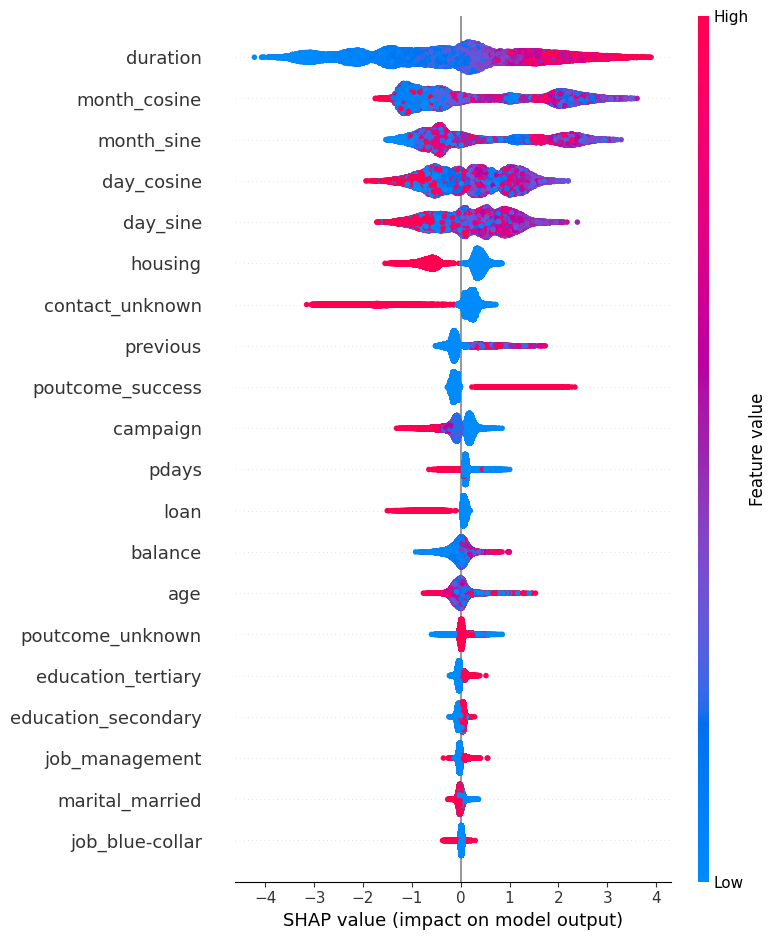

In [42]:

cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(categorical_columns)
features = np.concatenate([numeric_columns,cat_features])

explainer = shap.TreeExplainer(pipeline['model'])

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed, feature_names = features)

In [ ]:
## Further model assessment

In [43]:


def model_figures(y_target: pd.Series,
                  X_pred:pd.DataFrame,
                  y_pred: pd.Series,
                  model_name: str,
                  model):
    """Creates Cumulative Gain, Lift curves figures (good for ranking metrics) and ROC curve (original assessment metric)

      Args:
          y_target (pd.Series): Target variable
          X_pred (pd.DataFrame): Target dataframe
          y_pred (pd.Series): predicted values
          model_name (str): Model Name
          model: model instance

      Returns:
          a 3x1 figure displaying matplotlib figures

      Example usage:
          model_figures(y_target = y_val,
                        X_pred = X_pred,
                        y_pred = yhat_knn,
                        model_name = 'K-nearest neighboors'
                        model = model)

    """
    # create a 1 row, 2 column subplot
    fig, ax = plt.subplots(1, 3, figsize=(21, 7))

    # plot the cumulative gain curve on the left
    skplt.metrics.plot_cumulative_gain(y_target, y_pred, ax=ax[0])

    # plot the lift curve on the right
    skplt.metrics.plot_lift_curve(y_target, y_pred, ax=ax[1])

    #plot ROC curve
    skplt.metrics.plot_roc_curve(y_target, y_pred, ax=ax[2])

    # set some titles and labels
    ax[0].set_title('Cumulative Gain Curve: '+model_name)
    ax[0].set_xlabel('Percentage of sample')
    ax[0].set_ylabel('Gain')
    ax[1].set_title('Lift Curve: '+model_name)
    ax[1].set_xlabel('Percentage of sample')
    ax[1].set_ylabel('Lift')
    ax[1].legend(loc='upper right')
    ax[2].set_title('ROC Curve: '+model_name)
    ax[2].set_xlabel('False Positive Rate (FPR)')
    ax[2].set_ylabel('True Positive Rate (TPR)')

    return fig;


def model_assessment(models: dict,
                     x_train: pd.DataFrame,
                     y_train: pd.DataFrame,
                     x_test: pd.DataFrame,
                     y_test: pd.DataFrame,
                     destination_figures: str = 'figures',
                     destination_models: str = 'models'):
    """ Fits and assesses ML models based on ranking metrics (Cumulative and Lift curves)
    Args:
          models (dict): Model name (key) and model instance (item, including hyper-parameters)
          x_train (pd.dataframe): training dataframe
          y_train (pd.dataframe): training target
          x_test (pd.dataframe): testing dataframe
          y_test (pd.dataframe): testing target
          destination_figures (str): folder name where figures are to be stored (set as 'figures' by default)
          destination_figures (str): folder name where models are to be stored (set as 'models' by default)

      Returns:
          Creates directory where cumulative and lift curves plots and serialized (pickle) models are stored

      Example usage:
          model_assessment( models = models,
                            x_train = x_train,
                            y_train = y_train,
                            x_test = x_test
                            y_test = y_test,
                            destination_figures = 'figures',
                            destination_models = 'models')
    """
    # Creating directory to save figures
    models_main_path = Path.cwd()/ 'models'

    root_path = os.path.join(models_main_path, destination_figures)
    figures_path = Path(root_path)
    if figures_path.exists():
        print(f'[Info] Path {figures_path} already exists.')
    else:
        figures_path.mkdir(parents= True, exist_ok = True)
        print(f'[Info] Path{figures_path} created.')

    # Creating directory to save trained models
    root_path = os.path.join(models_main_path,destination_models)
    models_path = Path(root_path)
    if models_path.exists():
        print(f'[Info] Path {models_path} already exists.')
    else:
        models_path.mkdir(parents= True, exist_ok = True)
    print(f'[Info] Path {models_path} created.')

    # train each model and export the cumulative gains curve and lift curve and models
    for i, (name, model) in enumerate(models.items()):
        # fit the model to the training data
        model.fit(x_train, y_train)

        # Setting model object name
        file_name_model = name.lower().replace(' ','_')+'.pkl'

        # Exporting model
        with open(models_path/file_name_model, 'wb') as file:
          pickle.dump(model, file)

        # make predictions on the test data
        y_proba = model.predict_proba(x_test)

        # Setting model object name
        file_name = name.lower().replace(' ','_')+'.png'
        file_name_fig = figures_path/file_name

        # Exporting figure
        fig = model_figures(y_target= y_test,
                            X_pred = x_test,
                            y_pred= y_proba,
                            model_name = name,
                            model = model)

        fig.savefig(file_name_fig, dpi=300, bbox_inches='tight', pad_inches=0.2)
        print(f'[Info] {name} results exported successfully (model no. {i})')

    return None;

In [63]:
X = dataframe.drop('y', axis = 1)
y = dataframe['y']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 123)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan',
                                                   'campaign', 'pdays',
                                                   'previous', 'day_sine',
                                                   'day_cosine', 'month_sine',
                                                   'month_cosine',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome'])])),
                ('model',
                 XGBClassifier(base_score...
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [64]:
models = {
'BernoulliNB': BernoulliNB(),
'KNeighborsClassifier': KNeighborsClassifier(),
'LGBMClassifier' : lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42),
'RandomForestClassifier' : RandomForestClassifier(),
'XGBClassifier' : XGBClassifier(),
'XGBClassifier_finetuned' : XGBClassifier(colsample_bytree = 0.5,
                      gamma = 0.0,
                      learning_rate = 0.1,
                      max_depth = 12,
                      reg_alpha = 1,
                      reg_lambda = 1e-5),
            'LogisticRegression' : LogisticRegression()}
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
# y_train_transformed = pipeline.named_steps['preprocessor'].transform(y_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
# y_test_transformed = pipeline.named_steps['preprocessor'].transform(y_test)

[Info] Path /content/models/figures already exists.
[Info] Path /content/models/models already exists.
[Info] Path /content/models/models created.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] BernoulliNB results exported successfully (model no. 0)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] KNeighborsClassifier results exported successfully (model no. 1)
[LightGBM] [Info] Number of positive: 4074, number of negative: 31346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 35420, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115020 -> initscore=-2.040461
[LightGBM] [Info] Start training from score -2.040461


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] LGBMClassifier results exported successfully (model no. 2)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] RandomForestClassifier results exported successfully (model no. 3)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] XGBClassifier results exported successfully (model no. 4)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] XGBClassifier_finetuned results exported successfully (model no. 5)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


[Info] LogisticRegression results exported successfully (model no. 6)


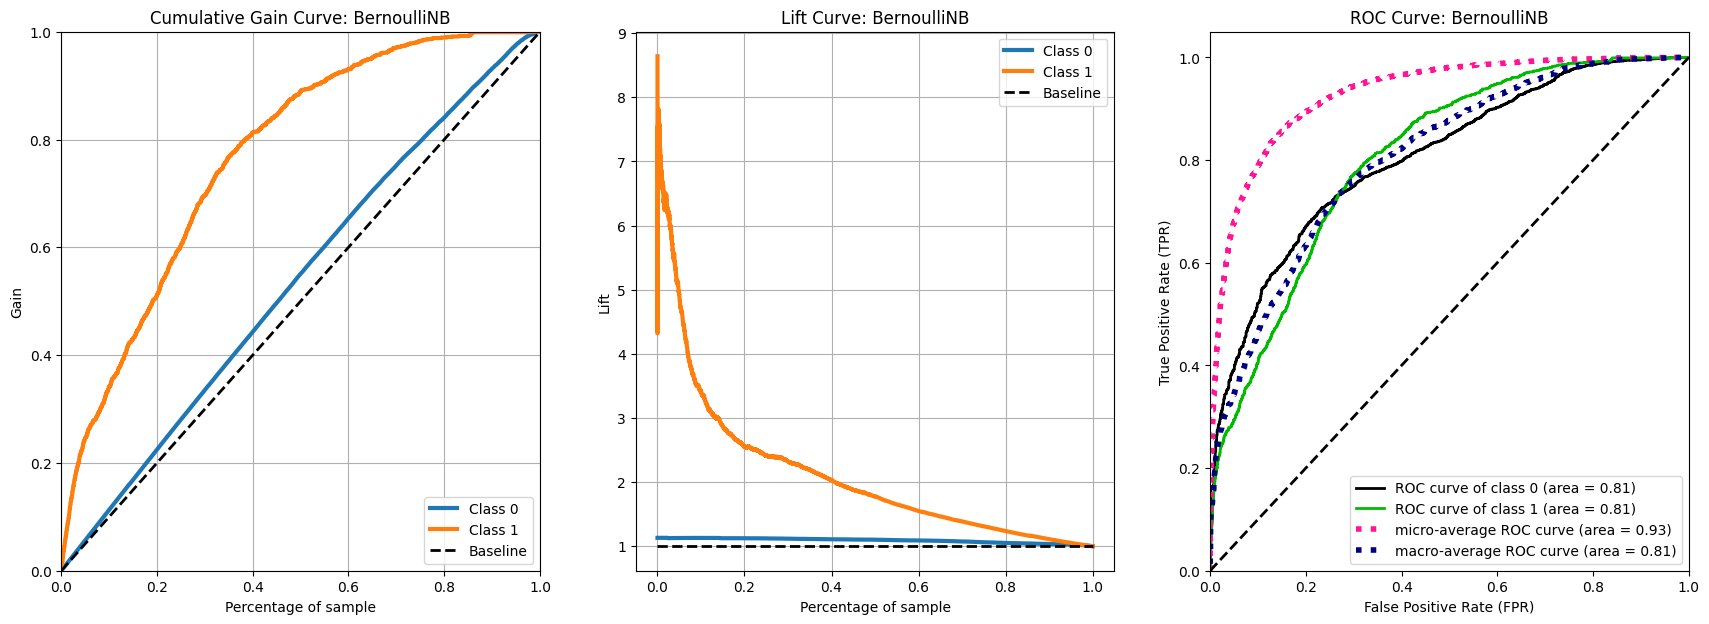

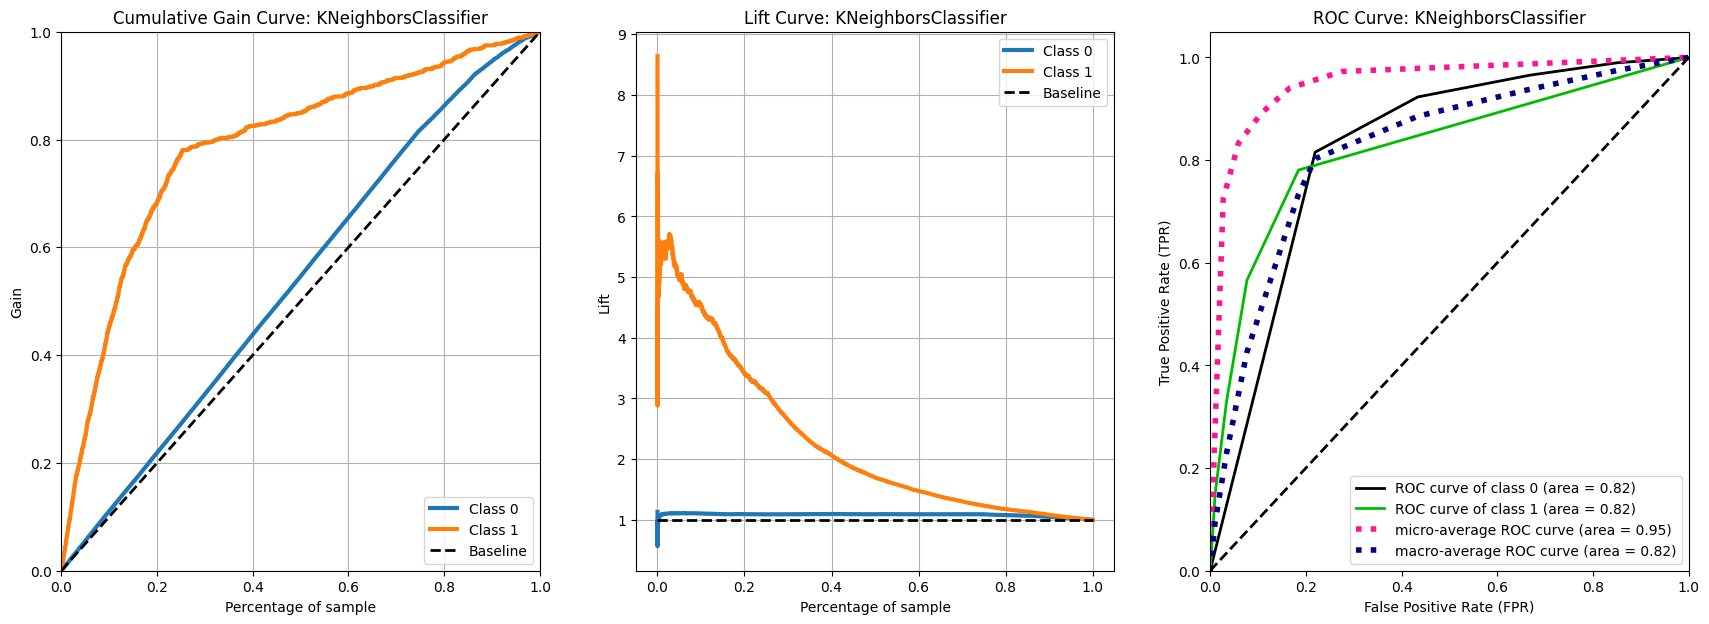

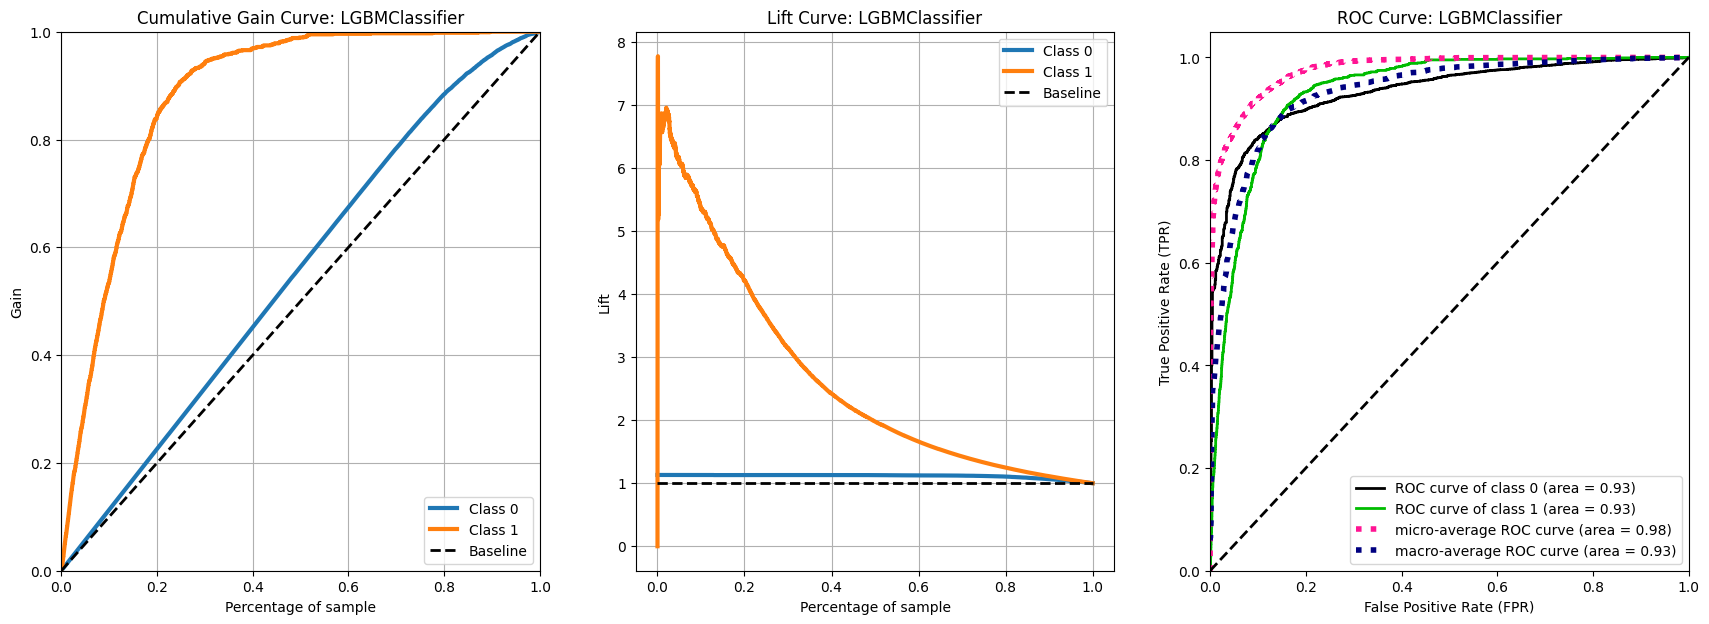

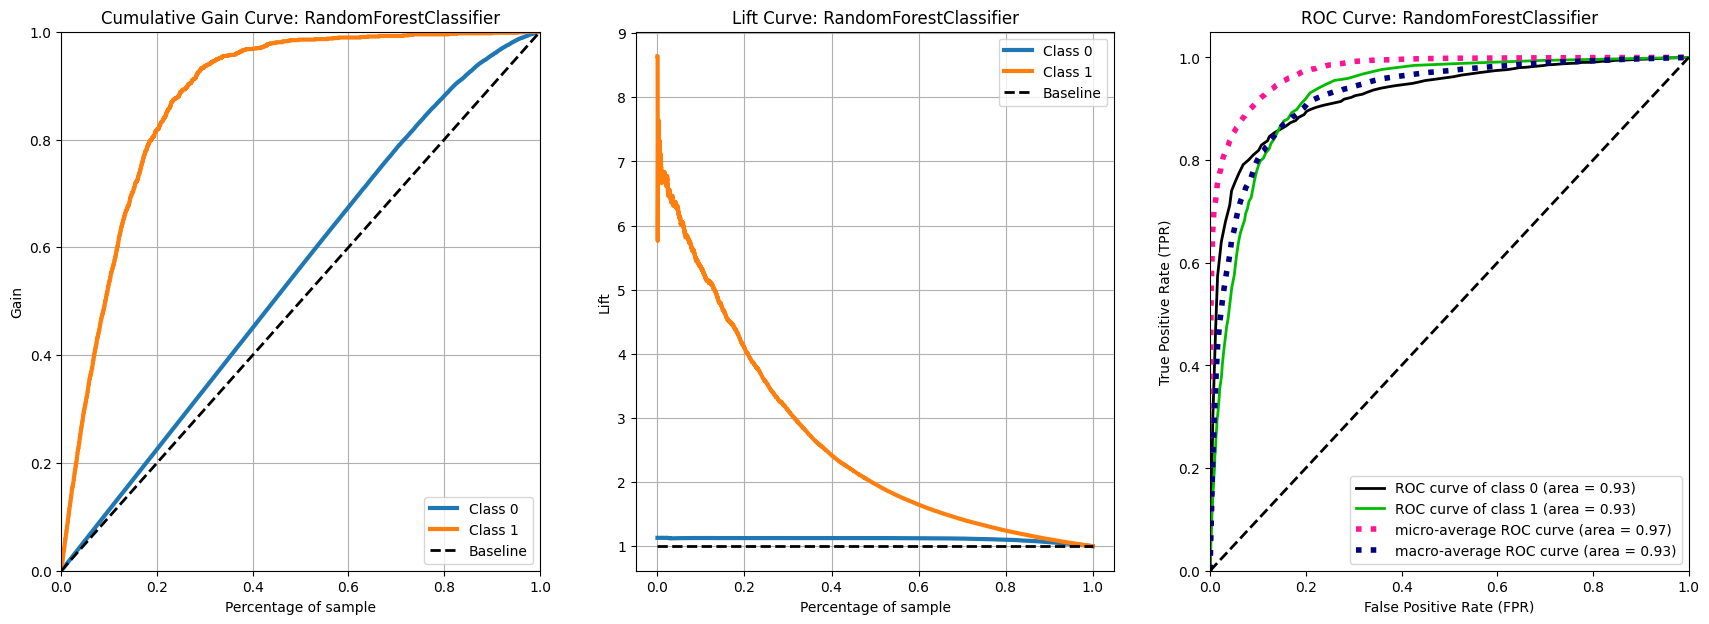

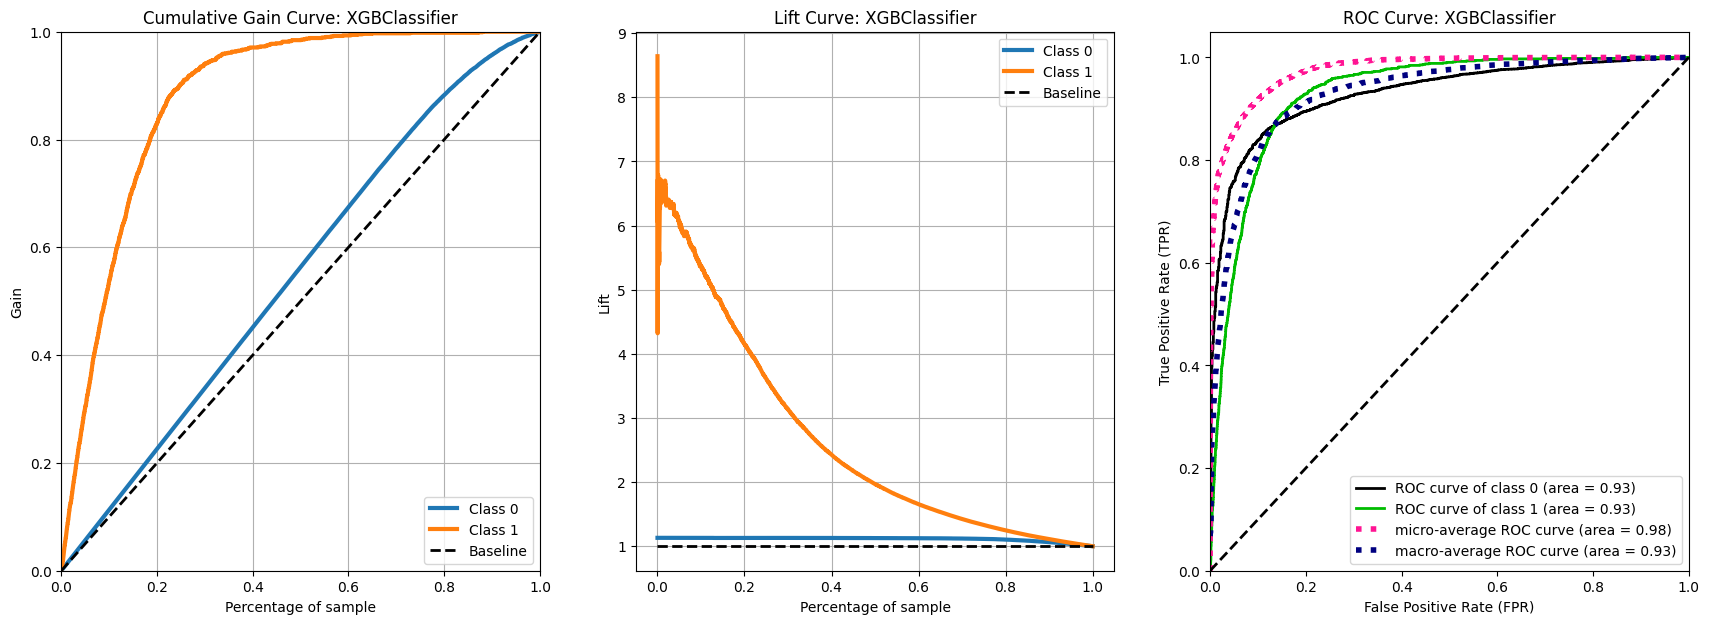

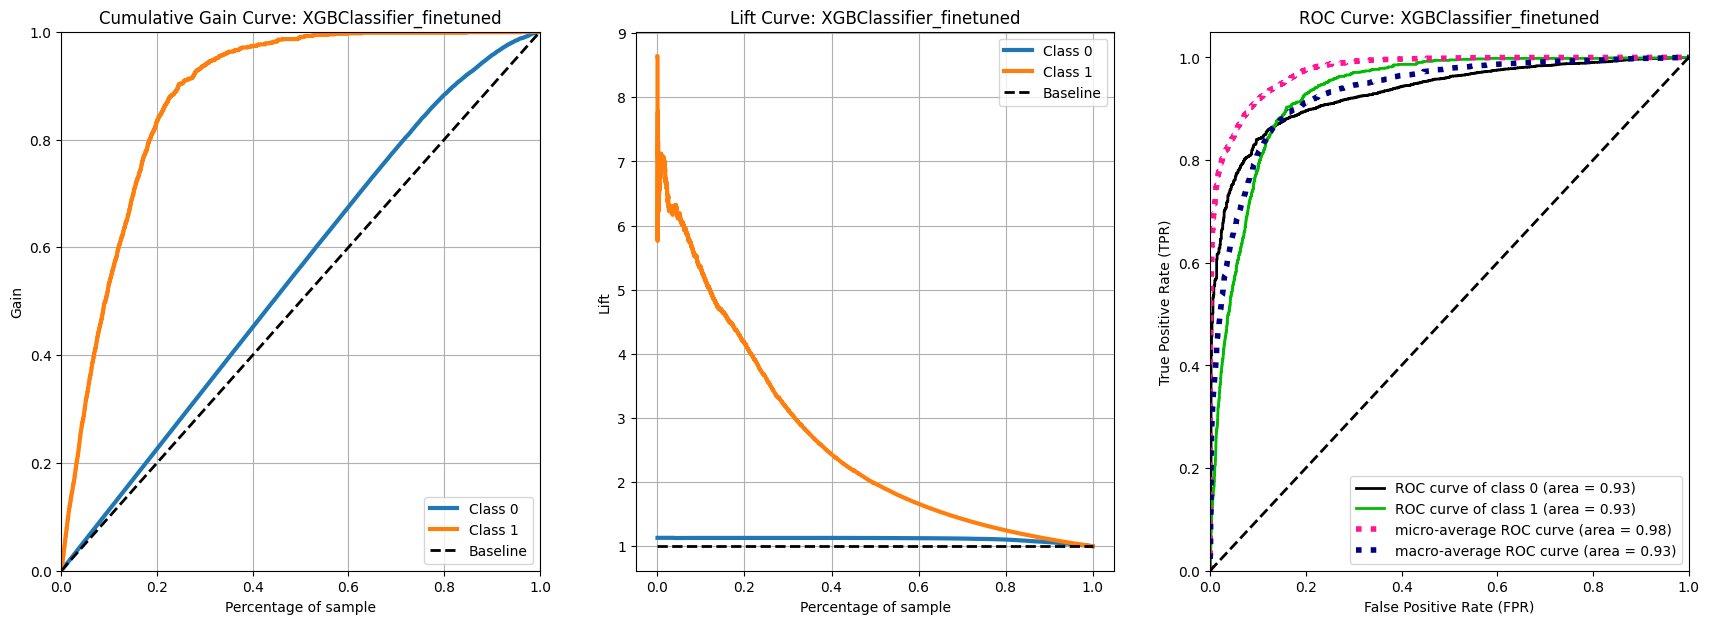

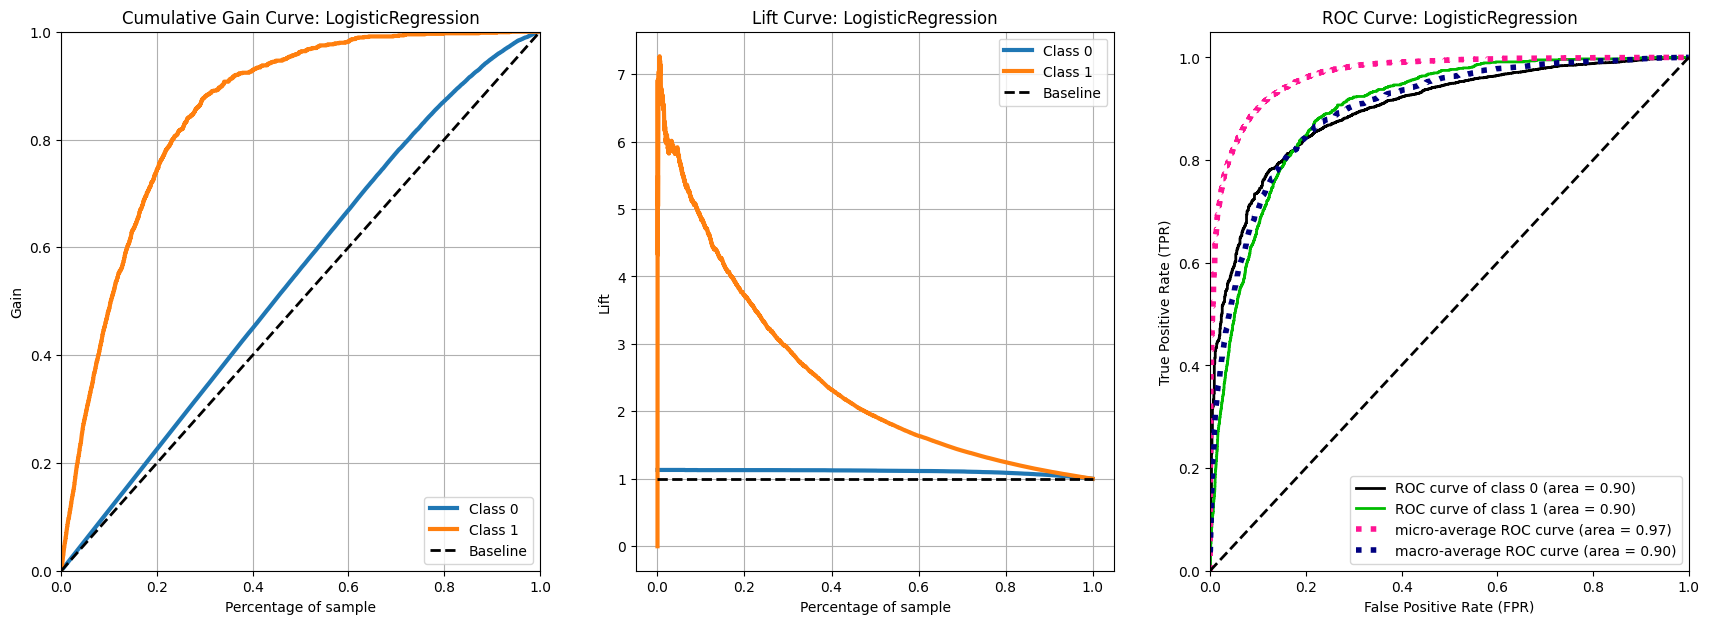

In [65]:
model_assessment(models = models,
                       x_train = X_train_transformed,
                       y_train = y_train,
                       x_test = X_test_transformed,
                       y_test = y_test)